# HOMEWORK 2 NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---
Student: Matteo Grandin
---
id: 2020374

# Unsupervised Deep Learning

### General overview
 In this homework you will learn how to implement and test neural network models for
solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen
before, the homework will be based on images of FashionMNIST. However, you can optionally explore
different image collections (e.g., Caltech or Cifar) or other datasets based on your interests. The basic tasks
for the homework will require to test and analyze the convolutional autoencoder implemented during the
Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar
performance considering the relatively small size of the FashionMNIST images. As for the previous
homework, you should explore the use of advanced optimizers and regularization methods. Learning
hyperparameters should be tuned using appropriate search procedures, and final accuracy should be
evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and
variational / adversarial architectures.

## Convolutional autoencoder
- implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and
some examples of image reconstruction; explore advanced optimizers and regularization methods

In [22]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import pickle

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu") #for debugging
print(f'Selected device: {device}')

if not os.path.exists('data/training'):
    os.makedirs('data/training')

Selected device: cuda


In [23]:
## Dataset
# training and validation will be performed on the training dataset
train_dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True)
# test dataset will only be used for evaluating final model performance
test_dataset  = torchvision.datasets.FashionMNIST('data', train=False, download=True)

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
num_labels = len(label_names)

In [24]:
## Data transformation
train_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform


In [25]:
## Model definition
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True),
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            #third linear layer
            nn.Linear(in_features=32, out_features=encoded_space_dim)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        ) 
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
        

In [26]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for (image_batch, _) in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add loss to the list
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    #print(f"Batch Train loss: {train_loss}")
    return train_loss

### Testing function
def validate_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for (image_batch, _) in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        #print(f"Batch Validation loss: {val_loss}")
    return val_loss.item()

In [27]:
#useful functions
def plot_losses(train_losses, val_losses, title, save_name=None, label1="Training loss", label2="Validation loss", max_y=0.2):
    fig = plt.figure(figsize=(12,4))
    plt.plot(train_losses, label=label1)
    plt.plot(val_losses, label=label2)
    plt.ylim(0,max_y)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    if save_name is None:
        save_name = title
    fig.savefig("images/"+save_name+".eps",format="eps", dpi=1200, bbox_inches="tight")
    plt.close()

def reset_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.reset_parameters()

## Optimize hyperparameters
- 1 pt: optimize hyperparameters using grid/random search or automatic tuning tools (e.g., Optuna)
- final accuracy should be evaluated using a cross-validation setup (concatenate training and test set like in here, than evaluate accuracy for each fold and take the avg https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/)

In [28]:
### Train loop
def train_loop(param_combinations, k_folds, num_epochs, train_dataset, device="cuda"):

    # initialize encoder and decoder
    enc,dec = Encoder(1), Decoder(1)

    val_losses = []

    for comb, params in enumerate(param_combinations):
        print(f"______________________{comb+1}/{len(param_combinations)}_______________________")
        lr, optimizer, wd, encoded_space_dim = params
        print(optimizer.__name__)
        comb_name = f"{optimizer.__name__}_lr_{lr:.0e}_wd_{wd:.0e}_esd_{encoded_space_dim}"
        print(f"Parameter combination {comb+1}: {comb_name}")

        # initialize models
        enc = Encoder(encoded_space_dim)
        dec = Decoder(encoded_space_dim)
        #reset weights
        enc.apply(reset_weights)
        dec.apply(reset_weights)
        # initialize optimizer
        params_to_optimize = [
            {'params': enc.parameters()},
            {'params': dec.parameters()}
        ]
        optim = optimizer(params_to_optimize, lr=lr, weight_decay=wd)
        if optimizer == torch.optim.SGD:
            optim.param_groups[0]['momentum'] = 0.9 # SGD momentum, SGD is bad
        # initialize loss function
        loss_fn = nn.MSELoss()
        # move to device
        enc.to(device)
        dec.to(device)

        ## train the model
        # perform cross validation 
        kfold = KFold(n_splits=k_folds, shuffle=True)
        #initialize trainining and validation losses
        # comb_train_losses = np.zeros(num_epochs)
        # comb_val_losses = np.zeros(num_epochs)
        comb_train_losses = []
        comb_val_losses = []
        for fold, (train_ids, validation_ids) in enumerate(kfold.split(train_dataset)):
            #print(f"Fold {fold}")
            # #reset weights # see comment in the above cell
            # enc.apply(reset_weights)
            # dec.apply(reset_weights)
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            validation_subsampler = torch.utils.data.SubsetRandomSampler(validation_ids)
            # dataloaders
            train_dataloader = DataLoader(train_dataset, batch_size=256, sampler=train_subsampler) 
            validation_dataloader = DataLoader(train_dataset, batch_size=256, sampler=validation_subsampler) 
            # train the model
            # i_train_losses = []
            # i_val_losses = []
            for epoch in tqdm(range(num_epochs)):
                #print(f"Epoch {epoch+1}/{num_epochs}")
                #train
                epoch_train_loss = train_epoch(enc, dec, device, train_dataloader, loss_fn, optim)
                #validate
                epoch_val_loss = validate_epoch(enc, dec, device, validation_dataloader, loss_fn)
                # store losses
                # i_train_losses.append(epoch_train_loss)
                # i_val_losses.append(epoch_val_loss)
                comb_train_losses.append(epoch_train_loss)
                comb_val_losses.append(epoch_val_loss)
                # # save model
                # torch.save(enc.state_dict(), f"data/training/encoder_{comb}_{fold}_{epoch}.pt")
                # torch.save(dec.state_dict(), f"data/training/decoder_{comb}_{fold}_{epoch}.pt")
            
            # comb_train_losses += np.array(i_train_losses)/k_folds
            # comb_val_losses += np.array(i_val_losses)/k_folds
        plot_losses(comb_train_losses, comb_val_losses, 
                        title=f"{optimizer.__name__} - lr:{lr:.0e} - weight decay: {wd:.0e} - ESD: {encoded_space_dim}",
                        save_name=f"loss_{comb+1}_{comb_name}_{k_folds*num_epochs}")
        # train and validation loss for paramters combination
        comb_train_loss = comb_train_losses[-1] # last epoch
        comb_val_loss = comb_val_losses[-1] # last epoch
        val_losses.append(comb_val_loss)
        print(f"Combination {comb+1} Train loss: {comb_train_loss}")
        print(f"Combination {comb+1} Validation loss: {comb_val_loss}")

        # # train the model on all the trainign data
        # enc.apply(reset_weights)
        # dec.apply(reset_weights)
        # for epoch in tqdm(range(num_epochs)):
        #     #print(f"Epoch {epoch+1}/{num_epochs}")
        #     #train
        #     epoch_train_loss = train_epoch(enc, dec, device, train_dataloader, loss_fn, optim)

        # save model
        torch.save(enc.state_dict(), f"data/training/encoder_{comb}_final_{num_epochs*k_folds}.pt")
        torch.save(dec.state_dict(), f"data/training/decoder_{comb}_final_{num_epochs*k_folds}.pt")
        # save losses
        with open(f"data/training/losses_{comb}.pkl", 'wb') as f:
            pickle.dump([comb_train_losses, comb_val_losses], f)

    return enc, dec, val_losses #return last, in case there is only one

In [29]:
# Once again, even if it's not perfectly accurate, weights will not be reset every fold
# and losses between folds will be concatenated, not averaged.
# this will lower the training time. The effective number of epochs is k_folds * num_epochs
k_folds = 3
num_epochs = 15 #15*3 ~ 2.5h for 18 combinations

#generate parameters combinations
learning_rates = [5e-3, 1e-3, 5e-4] #[5e-3, 1e-3, 5e-4]
optimizers = [torch.optim.Adam] #[torch.optim.Adam, torch.optim.SGD]
optimizer_names = ["adam"] #["adam", "sgd"]
weight_decays = [1e-5, 1e-4, 1e-3] #[1e-5, 1e-4, 1e-3]
encoded_space_dims = [10, 30]

param_combinations = []
for lr in learning_rates:
    for opt in optimizers:
        for wd in weight_decays:
            for esd in encoded_space_dims:
                param_combinations.append([lr, opt, wd, esd])
print(f"Number of combinations = {len(param_combinations)}")

Number of combinations = 18


______________________1/2_______________________
Adam
Parameter combination 1: Adam_lr_5e-03_wd_1e-05_esd_10


100%|██████████| 1/1 [00:09<00:00,  9.44s/it]


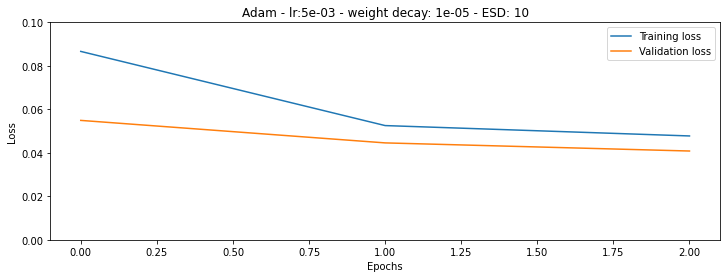

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Combination 1 Train loss: 0.04776015505194664
Combination 1 Validation loss: 0.040829889476299286
______________________2/2_______________________
Adam
Parameter combination 2: Adam_lr_5e-03_wd_1e-05_esd_30


100%|██████████| 1/1 [00:09<00:00,  9.51s/it]


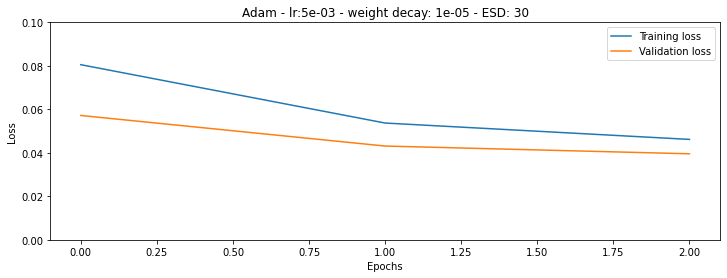

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Combination 2 Train loss: 0.04617105101703838
Combination 2 Validation loss: 0.03955410420894623
Best combination: [0.005, <class 'torch.optim.adam.Adam'>, 1e-05, 30]


In [30]:
## GRID SEARCH TRAINING
_, _, val_losses = train_loop(param_combinations, k_folds=k_folds, num_epochs=num_epochs, train_dataset=train_dataset, device=device)
#find the index of the best combination
best_comb_index = np.argmin(val_losses)
best_comb = param_combinations[best_comb_index]
print(f"Best combination: {best_comb}")

# 10-dimensional encoded space

In [70]:
#parameters
num_epochs10 = 100 #20s*epoch ~ 0.5h
encoded_space_dim = 10
encoder10, decoder10 = Encoder(encoded_space_dim), Decoder(encoded_space_dim)
optim10 = torch.optim.Adam(list(encoder10.parameters()) + list(decoder10.parameters()), lr=1e-3, weight_decay=1e-5)
loss_fn10 = nn.MSELoss()
train_losses = []
val_losses = []

In [ ]:
# function to get model accuracy
def get_accuracy(encoder, dataset, single_layer=None):
    this_dataloader = DataLoader(dataset, batch_size=20000)
    correct = 0
    total = 0
    with torch.no_grad():
        for (data, label) in tqdm(this_dataloader):
            data, label = data.to(device), label.to(device)
            # Compute the output
            output = encoder(data)
            if single_layer is not None:
                output = single_layer(output)
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the total number of correct predictions
            correct += pred.eq(label.view_as(pred)).sum() #.item()
            # Add to the total number of predictions
            total += data.shape[0]
    return correct/total

### Test on examples
def test_on_example(n_example, encoder, decoder, title, save_name=None, test_dataset=test_dataset):
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[n_example][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image')
    plt.tight_layout()
    axs[0].axis('off')
    axs[1].axis('off')
    plt.pause(0.1)
    plt.show()
    if save_name is None:
        save_name = title
    fig.savefig(f"images/{save_name}.png", dpi=1000, bbox_inches='tight')
    plt.close()

#train function
def train(enc, dec, epochs, train_dataset, test_dataset, loss_fn, optim, device):
    # Define the dataloader
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    # Define the lists to store the losses
    train_losses = []
    test_losses = []
    enc, dec = enc.to(device), dec.to(device)
    enc.train()
    dec.train()
    # Train the model
    for epoch in tqdm(range(epochs)):
        # Train the model
        train_loss = train_epoch(enc, dec, device, train_loader, loss_fn, optim)
        # Validate the model
        test_loss = validate_epoch(enc, dec, device, test_loader, loss_fn)
        # Add the loss to the list
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return enc, dec, train_losses, test_losses


100%|██████████| 3/3 [01:08<00:00, 22.71s/it]


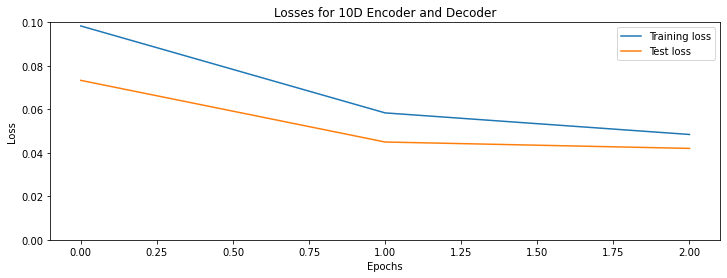

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [72]:
# execute the training loop
# decide to load or not the pretrained model
load_good_model = False

# pretrained_encoder_path = "good_models/encoder10_0_final_99.pt"
# pretrained_decoder_path = "good_models/decoder10_0_final_99.pt"

if not load_good_model: #train from scratch
    encoder10, decoder10, train_losses, test_losses = train(encoder10, decoder10, num_epochs10, train_dataset, test_dataset, loss_fn10, optim10, device)
    # save model
    torch.save(encoder10.state_dict(), f"good_models/encoder10_final_{num_epochs10}.pt")
    torch.save(decoder10.state_dict(), f"good_models/decoder10_final_{num_epochs10}.pt")
    # save losses
    with open(f"good_models/losses10_{num_epochs10}.pkl", 'wb') as f:
        pickle.dump([train_losses, test_losses], f)
else: #load pretrained model
    encoder10.load_state_dict(torch.load(f"good_models/encoder10_final_{num_epochs10}.pt"))
    decoder10.load_state_dict(torch.load(f"good_models/decoder10_final_{num_epochs10}.pt"))
    print("Loaded pretrained model")
    #load losses
    with open(f"good_models/losses10_{num_epochs10}.pkl", 'rb') as f:
        train_losses, test_losses = pickle.load(f)

#plot losses
plot_losses(train_losses, test_losses, title="Losses for 10D Encoder and Decoder", save_name=f"losses10_{num_epochs10}", label2="Test loss")

In [73]:
### Test the model
# calculate loss on training set
encoder10, decoder10 = encoder10.to(device), decoder10.to(device)
train_loss = validate_epoch(encoder10, decoder10, device, DataLoader(train_dataset, batch_size=60000), nn.MSELoss())
print(f"Train loss: {train_loss}")
# calculate loss on test set
test_loss = validate_epoch(encoder10, decoder10, device, DataLoader(test_dataset, batch_size=20000), nn.MSELoss())
print(f"Test loss: {test_loss}")

Train loss: 0.04224821552634239
Test loss: 0.042032040655612946


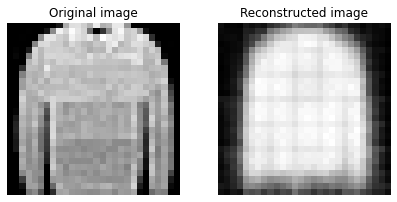

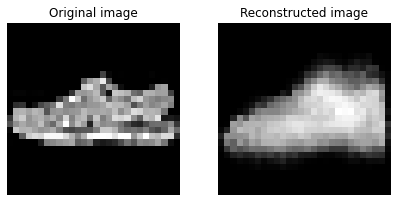

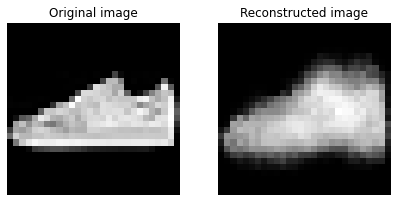

In [74]:
for i in range(20,23):
    test_on_example(i, encoder10, decoder10, title="Test on example 10D-ESD", save_name=f"10D_reconstruction_example_{i}")

## 10-D Supervised fine tuning and comparison with supervised methods
- 1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task, and compare
classification accuracy and learning speed with results achieved in Homework 1

In [94]:
## Fine tuning
torch.manual_seed(0)
mse_multiplier = 8
step2_num_epochs = 80
target_losses, reconstruction_losses = [], []

#load model
if load_good_model:
    decoder10.load_state_dict(torch.load(f'good_models/decoder10_finetuned_{step2_num_epochs}.pt'))
    encoder10.load_state_dict(torch.load(f'good_models/encoder10_finetuned_{step2_num_epochs}.pt'))
    print("Loaded pretrained models")
    #load losses
    with open(f"good_models/losses10_finetuned_{step2_num_epochs}.pkl", 'rb') as f:
        target_losses, reconstruction_losses = pickle.load(f)
else:
    # dataloader
    train_dataloader_2 = DataLoader(train_dataset, batch_size=256, shuffle=True)
    #loss
    loss_fn_2 = nn.CrossEntropyLoss()
    dec_loss_fn = nn.MSELoss()
    #optimizer
    params_to_optimize = [
                {'params': encoder10.parameters()},
                {'params': decoder10.parameters()}
            ]
    optimizer_2 = torch.optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-5)
    # to gpu
    encoder10.to(device)
    decoder10.to(device)

    #train loop
    target_losses = []
    reconstruction_losses = []
    for epoch in range(step2_num_epochs):
        print(f"Epoch {epoch+1}/{step2_num_epochs}")
        encoder10.train()
        decoder10.train()
        epoch_losses2 = []
        dec_losses = []
        for (data, label) in tqdm(train_dataloader_2):
            # Zero the gradients
            optimizer_2.zero_grad()
            ## DECODER + SINGLE LAYER MATCHER TRAINING
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # use pretrained encoder to encode the data
            encoded_data = encoder10(data)
            assert encoded_data.shape == target.shape
            # Compute the loss
            loss2 = loss_fn_2(encoded_data, target)
            # Compute the gradients
            loss2.backward(retain_graph=True)
            ## DECODER TRAINING
            # Compute the output
            decoded_data = decoder10(encoded_data)
            # Compute the loss
            dec_loss = mse_multiplier*dec_loss_fn(decoded_data, data) # for more weightage
            # Compute the gradients
            dec_loss.backward()

            # Update the weights
            optimizer_2.step()

            #batch loss
            loss_batch2 = loss2.item()
            epoch_losses2.append(loss_batch2)
            dec_loss_batch = dec_loss.item()
            dec_losses.append(dec_loss_batch)

        # Return the average training loss
        epoch_loss2 = np.mean(epoch_losses2)
        print(f"target loss: {epoch_loss2}")
        target_losses.append(epoch_loss2)
        dec_loss = np.mean(dec_losses)
        print(f"reconstruction loss (x{mse_multiplier}): {dec_loss}")
        reconstruction_losses.append(dec_loss)

    #plot losses
    plot_losses(target_losses, reconstruction_losses, 
                    title="Target and Reconstruction Losses 10-D Finetuning", save_name=f"losses_encoder10_finetuned_{step2_num_epochs}",
                    label1="Target loss",label2="Reconstruction loss",max_y=1.5)
    
    torch.save(decoder10.state_dict(), f'good_models/decoder10_finetuned_{step2_num_epochs}.pt')
    torch.save(encoder10.state_dict(), f'good_models/encoder10_finetuned_{step2_num_epochs}.pt')
    #save losses
    with open(f"good_models/losses10_finetuned_{step2_num_epochs}.pkl", 'wb') as f:
        pickle.dump((target_losses, reconstruction_losses), f)

#accuracy
step_2_train_accuracy = get_accuracy(encoder10, train_dataset)
step_2_test_accuracy = get_accuracy(encoder10, test_dataset)
#print train and test accuracy with 3 decimal places
print(f"Train Accuracy After Decoder Tuning: {round(step_2_train_accuracy.item()*100, 1)} %")
print(f"Test Accuracy After Decoder Tuning: {round(step_2_test_accuracy.item()*100, 1)} %")

Loaded pretrained models


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Train Accuracy After Decoder Tuning: 72.8 %
Test Accuracy After Decoder Tuning: 72.1 %


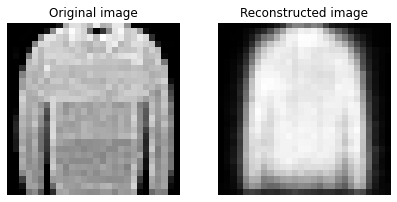

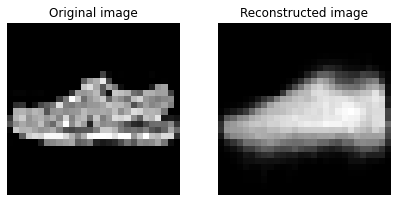

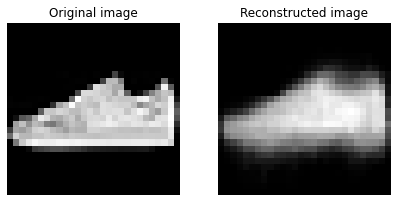

In [76]:
#test on examples
for i in range(20,23):
    test_on_example(i, encoder10, decoder10, title="Test after supervised fine tuning", save_name=f"10D_reconstruction_example_finetuned_{i}")

## 10-D Latent space exploration and generation of new samples
- 2 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

### PCA

In [77]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder10.eval()
    with torch.no_grad():
        encoded_img  = encoder10(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
import plotly.express as px
fig2a = px.scatter(encoded_samples_reduced_PCA, x=0, y =1, 
    color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig2a.show()
#save figure as eps
fig2a.write_image(f'images/10D_finetuned_PCA.eps', width=2000, height=700)

# very interesting but computationally expensive
# pca3 = PCA(n_components=3)
# encoded_samples_reduced_PCA3 = pca3.fit_transform(encoded_samples)
# fig2b = px.scatter_3d(encoded_samples_reduced_PCA3, x=0, y=1, z=2, 
#     color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
# fig2b.show()


100%|██████████| 10000/10000 [00:20<00:00, 479.17it/s]


### t-SNE

In [78]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
fig3a = px.scatter(encoded_samples_reduced_TSNE, x=0, y =1, 
    color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig3a.show()
fig3a.write_image(f'images/10D_finetuned_TSNE.eps', width=2000, height=700)

# very interesting but computationally expensive
# tsne3 = TSNE(n_components=3)
# encoded_samples_reduced_TSNE3 = tsne3.fit_transform(encoded_samples)
# fig3b = px.scatter_3d(encoded_samples_reduced_TSNE3, x=0, y=1, z=2,
#     color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
# fig3b.show()

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



evident how the TSNE is nonlinear, shirt and t-shirt, coat and pullover,  are very hard to distinguish.

### Generate new samples

In [79]:
# New samples are generated only in the case of 2 hidden dimensions, since it's much more intuitive to pick samples

# 2-dimensional encoded space

## Training

100%|██████████| 3/3 [00:56<00:00, 18.89s/it]


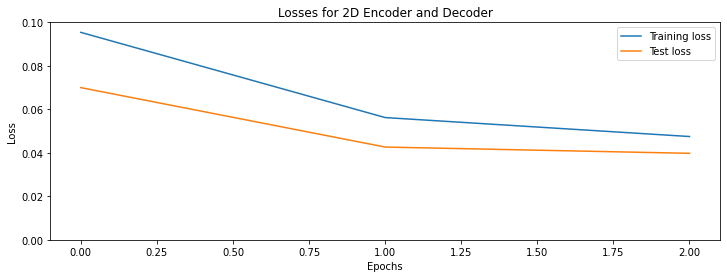

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [82]:
#parameters
num_epochs2 = 100 #20s*epoch 
encoded_space_dim = 2
encoder2, decoder2 = Encoder(encoded_space_dim), Decoder(encoded_space_dim)
optim2 = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr=1e-3, weight_decay=1e-5)
loss_fn2 = nn.MSELoss()
train_losses = []
val_losses = []

# execute the training loop
# decide to load or not the pretrained model
load_good_model2 = False

# pretrained_encoder_path = "good_models/encoder_0_final_39.pt"
# pretrained_decoder_path = "good_models/decoder_0_final_39.pt"

if not load_good_model: #train from scratch
    encoder2, decoder2, train_losses, test_losses = train(encoder2, decoder2, num_epochs2, train_dataset, test_dataset, loss_fn2, optim2, device)
    # save model
    torch.save(encoder2.state_dict(), f"good_models/encoder2_final_{num_epochs2}.pt")
    torch.save(decoder2.state_dict(), f"good_models/decoder2_final_{num_epochs2}.pt")
    # save losses
    with open(f"good_models/losses2_{num_epochs2}.pkl", 'wb') as f:
        pickle.dump([train_losses, test_losses], f)
else: #load pretrained model
    encoder2.load_state_dict(torch.load(f"good_models/encoder2_final_{num_epochs2}.pt"))
    decoder2.load_state_dict(torch.load(f"good_models/decoder2_final_{num_epochs2}.pt"))
    print("Loaded pretrained model")
    #load losses
    with open(f"good_models/losses2_{num_epochs2}.pkl", 'rb') as f:
        train_losses, test_losses = pickle.load(f)

#plot losses
plot_losses(train_losses, test_losses, title="Losses for 2D Encoder and Decoder", save_name=f"losses2_{num_epochs2}", label2="Test loss")

Train loss: 0.039907317608594894
Test loss: 0.03976644575595856


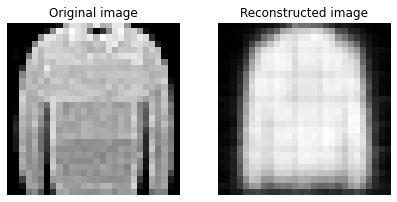

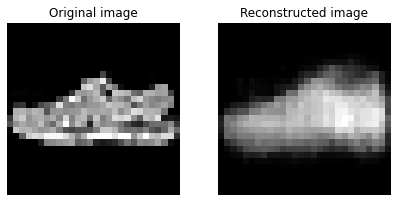

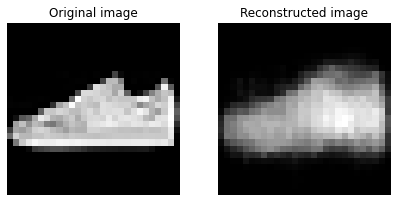

In [83]:
### Test the model
# calculate loss on training set
encoder2, decoder2 = encoder2.to(device), decoder2.to(device)
train_loss = validate_epoch(encoder2, decoder2, device, DataLoader(train_dataset, batch_size=60000), nn.MSELoss())
print(f"Train loss: {train_loss}")
# calculate loss on test set
test_loss = validate_epoch(encoder2, decoder2, device, DataLoader(test_dataset, batch_size=20000), nn.MSELoss())
print(f"Test loss: {test_loss}")

#test on examples
for i in range(20,23):
    test_on_example(i, encoder2, decoder2, title="Test on example 2D-ESD", save_name=f"2D_reconstruction_example_{i}")

In [84]:
### Get the encoded representation of the test samples
def plot_encoded_samples(test_dataset, device, encoder2, title):
    encoded_samples = []
    for sample in tqdm(test_dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder2.eval()
        with torch.no_grad():
            encoded_img  = encoder2(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)

    # Convert to a dataframe
    encoded_samples = pd.DataFrame(encoded_samples)
    encoded_samples

    import plotly.express as px
    %pip install -U kaleido
    fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
        color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
    #set title
    fig.update_layout(title=title)
    fig.show()
    return fig

fig1 = plot_encoded_samples(test_dataset, device, encoder2, "2-D Encoded Test Samples Before Finetuning")
#save fig
if not os.path.exists("images"):
    os.mkdir("images")
fig1.write_image(f"images/encoded2_samples_before.eps")

100%|██████████| 10000/10000 [00:24<00:00, 414.29it/s]


Note: you may need to restart the kernel to use updated packages.


## 2-D Supervised fine tuning and comparison with supervised methods
- 1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task, and compare
classification accuracy and learning speed with results achieved in Homework 1

To fine tune the encoder2, the idea is to create a set of weights from the hidden representation to the output target encoded as a 10-vector (one-hot encoding vector of the class, like class 3 => [0001000000])). The idea for training is divided in steps:
- step 1: fix the encoder2/decoder2 weights and train only the new layer
- step 2: for a specified number of epochs repeat:
    - fix decoder2 and train encoder2 using nn.CrossEntropyLoss() wrt the target
    - fix encoder2 and train decoder2 using nn.MSELoss() wrt to the initial image

In [85]:
## step 1: single layer NN training
# create the single layer NN to match the encoded_space_dim to the 10-dim one-encoded vector
class SingleLayerNN(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc = nn.Linear(encoded_space_dim, 10)
    def forward(self, x):
        return self.fc(x)

slm = SingleLayerNN(encoded_space_dim) #slm = single layer matcher

# step 1: single layer NN training
torch.manual_seed(0)
#params
single_layer_num_epochs = 10
# dataloader
slm_train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#loss
sl_loss_fn = nn.CrossEntropyLoss()
#optimizer
sl_optimizer = torch.optim.Adam(slm.parameters(), lr=1e-3)
# to gpu
slm.to(device)

if not load_good_model2:
    #train loop
    for epoch in range(single_layer_num_epochs):
        print(f"Epoch {epoch+1}/{single_layer_num_epochs}")
        slm.train()
        epoch_loss = []
        for (data, label) in tqdm(slm_train_dataloader):
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # use pretrained encoder2 to encode the data
            encoded_data = encoder2(data)
            # Zero the gradients
            sl_optimizer.zero_grad()
            # Compute the output
            output = slm(encoded_data)
            assert output.shape == target.shape
            # Compute the loss
            loss = sl_loss_fn(output, target)
            # Compute the gradients
            loss.backward()
            # Update the weights
            sl_optimizer.step()
            #batch loss
            loss_batch = loss.item()
            epoch_loss.append(loss_batch)
        # Return the average training loss
        epoch_loss = np.mean(epoch_loss)
        print(f"epoch loss: {epoch_loss}")

    step_1_train_accuracy = get_accuracy(encoder2, train_dataset, single_layer=slm)
    step_1_test_accuracy = get_accuracy(encoder2, test_dataset, single_layer=slm)
    #print train and test accuracy with 3 decimal places
    print(f"Train Accuracy WITHOUT Decoder tuning: {round(step_1_train_accuracy.item()*100, 1)} %")
    print(f"Test Accuracy WITHOUT Decoder tuning: {round(step_1_test_accuracy.item()*100, 1)} %")

Epoch 1/5


100%|██████████| 235/235 [00:08<00:00, 28.91it/s]


epoch loss: 7.359340182771074
Epoch 2/5


100%|██████████| 235/235 [00:11<00:00, 21.15it/s]


epoch loss: 3.128478306912361
Epoch 3/5


100%|██████████| 235/235 [00:09<00:00, 24.63it/s]


epoch loss: 1.8291144482632902
Epoch 4/5


100%|██████████| 235/235 [00:09<00:00, 24.81it/s]


epoch loss: 1.580316542057281
Epoch 5/5


100%|██████████| 235/235 [00:09<00:00, 24.14it/s]


epoch loss: 1.4742496211478051


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Train Accuracy WITHOUT Decoder tuning: 46.0 %
Test Accuracy WITHOUT Decoder tuning: 46.0 %


- step 2: for a specified number of epochs repeat:
    - fix decoder2 and train encoder2 using nn.CrossEntropyLoss() wrt the target
    - fix encoder2 and train decoder2 using nn.MSELoss() wrt to the initial image

It would be interesting to not fix the encoder2 when the decoder2 is training, in other words use both losses at the same time to update the encoder2. 

UPDATE: it is possible since losses are accumulated when using .backward(). therefore we can try to train for correct target and for correct reconstuction at the same time. Note: recosntruction loss needs to be weighted to match the target loss.

Epoch 1/2


100%|██████████| 235/235 [00:18<00:00, 12.78it/s]


target loss: 0.8465124277358359
reconstruction loss (x5): 0.2574286944054543
Epoch 2/2


100%|██████████| 235/235 [00:17<00:00, 13.62it/s]


target loss: 0.8157361421179264
reconstruction loss (x5): 0.2564977042218472


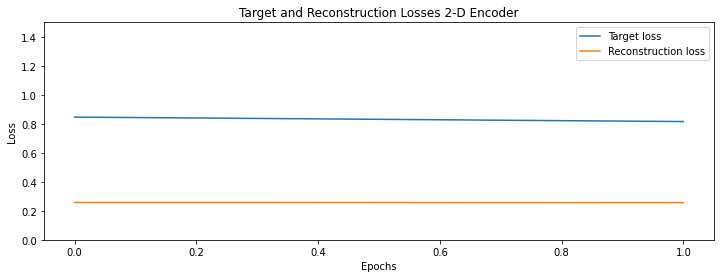

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Train Accuracy WITH Decoder tuning: 71.59833526611328 %
Test Accuracy WITH Decoder tuning: 71.37999725341797 %


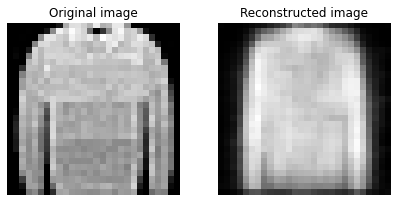

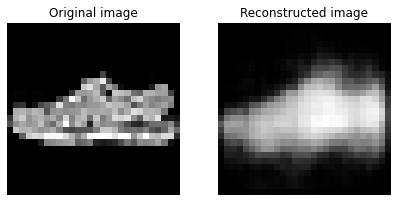

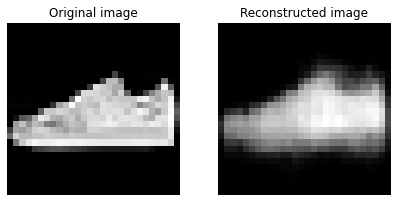

In [96]:
# step 2: decoder2 training
torch.manual_seed(0)
step2_num_epochs = 50
target_losses = []
reconstruction_losses = []

#load model
if load_good_model2:
    slm.load_state_dict(torch.load(f'good_models/single_layer_model_{single_layer_num_epochs}.pt'))
    decoder2.load_state_dict(torch.load(f'good_models/decoder2_finetuned_{step2_num_epochs}.pt'))
    #load losses with pickle
    with open('good_models/losses_target_reconstr_encoder2_slm.pkl', 'wb') as f:
        target_losses, reconstruction_losses = pickle.load(f)
    print("Loaded pretrained models")

else:
    # dataloader
    train_dataloader_2 = DataLoader(train_dataset, batch_size=256, shuffle=True)
    #loss
    loss_fn_2 = nn.CrossEntropyLoss()
    dec_loss_fn = nn.MSELoss()
    #optimizer
    params_to_optimize = [
                {'params': encoder2.parameters()},
                {'params': slm.parameters()}, 
                {'params': decoder2.parameters()}
            ]
    optimizer_2 = torch.optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-5)
    # to gpu
    slm.to(device)
    encoder2.to(device)
    decoder2.to(device)

    #train loop
    target_losses = []
    reconstruction_losses = []
    for epoch in range(step2_num_epochs):
        print(f"Epoch {epoch+1}/{step2_num_epochs}")
        slm.train()
        encoder2.train()
        decoder2.train()
        epoch_losses2 = []
        dec_losses = []
        for (data, label) in tqdm(train_dataloader_2):
            # Zero the gradients
            optimizer_2.zero_grad()
            ## DECODER + SINGLE LAYER MATCHER TRAINING
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # use pretrained encoder2 to encode the data
            encoded_data = encoder2(data)
            # Compute the output
            output = slm(encoded_data)
            # Compute the loss
            loss2 = loss_fn_2(output, target)
            # Compute the gradients
            loss2.backward(retain_graph=True)
            ## DECODER TRAINING
            # Compute the output
            decoded_data = decoder2(encoded_data)
            # Compute the loss
            dec_loss = 5*dec_loss_fn(decoded_data, data) #5x for more weightage
            # Compute the gradients
            dec_loss.backward()

            # Update the weights
            optimizer_2.step()

            #batch loss
            loss_batch2 = loss2.item()
            epoch_losses2.append(loss_batch2)
            dec_loss_batch = dec_loss.item()
            dec_losses.append(dec_loss_batch)

        # Return the average training loss
        epoch_loss2 = np.mean(epoch_losses2)
        print(f"target loss: {epoch_loss2}")
        target_losses.append(epoch_loss2)
        dec_loss = np.mean(dec_losses)
        print(f"reconstruction loss (x5): {dec_loss}")
        reconstruction_losses.append(dec_loss)

    #plot losses
    plot_losses(target_losses, reconstruction_losses, 
                    title="Target and Reconstruction Losses 2-D Encoder", save_name="losses_target_reconstr_encoder2_slm",
                    label1="Target loss",label2="Reconstruction loss",max_y=1.5)
    
    torch.save(slm.state_dict(), f'good_models/single_layer_model_{single_layer_num_epochs}.pt')
    torch.save(decoder2.state_dict(), f'good_models/decoder2_finetuned_{step2_num_epochs}.pt')
    #save losses using pickle
    with open('good_models/losses_target_reconstr_encoder2_slm.pkl', 'wb') as f:
        pickle.dump([target_losses, reconstruction_losses], f)


#accuracy
step_2_train_accuracy = get_accuracy(encoder2, train_dataset, single_layer=slm)
step_2_test_accuracy = get_accuracy(encoder2, test_dataset, single_layer=slm)
#print train and test accuracy with 3 decimal places
print(f"Train Accuracy WITH Decoder tuning: {step_2_train_accuracy*100} %")
print(f"Test Accuracy WITH Decoder tuning: {step_2_test_accuracy*100} %")

#test on examples
for i in range(20,23):
    test_on_example(i, encoder2, decoder2, title="Test After Tuning 2D-ESD", save_name=f"2D_reconstruction_example_{i}")

In [97]:
## Plot encoded samples after tuning the decoder
fig2 = plot_encoded_samples(test_dataset, device, encoder2, "2-D Encoded Test Samples After Fine Tuning")
fig2.write_image(f"images/encoded2_samples_after.eps")

100%|██████████| 10000/10000 [00:18<00:00, 528.89it/s]


Note: you may need to restart the kernel to use updated packages.


## Latent space exploration and generation of new samples
- 2 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

Since we are dealing with only 2 hidden dimensions, PCA or t-SNE doesn't make sense.

In this section we will analyze only the new samples generation section

### New samples generation

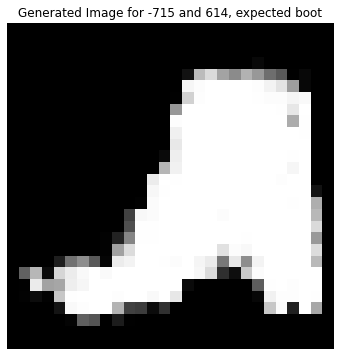

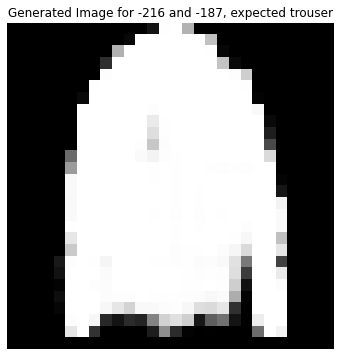

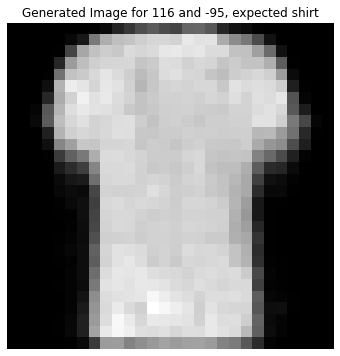

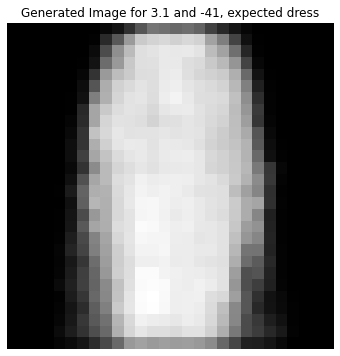

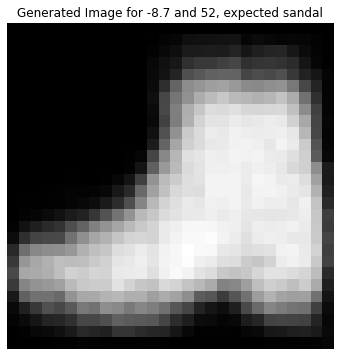

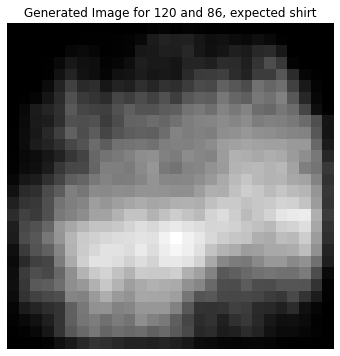

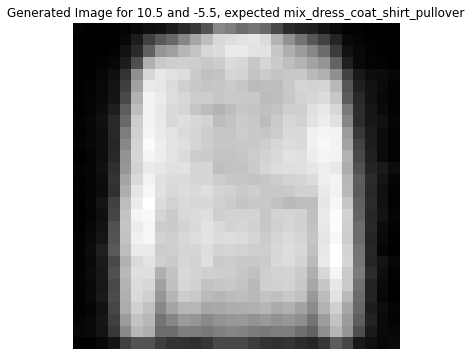

In [98]:
def generate_sample(x, y, expected, decoder2=decoder2):
    encoded_value = torch.tensor([x,y], dtype=torch.float32).unsqueeze(0).to(device)
    #decode sample
    decoder2.eval()
    with torch.no_grad():
        generated_img = decoder2(encoded_value)
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.title(f"Generated Image for {x} and {y}, expected {expected}")
    plt.axis('off')
    plt.show()
    #save plt
    fig.savefig(f"images/generated_sample_{expected}.png", bbox_inches='tight')

## Note: after a retrain these could be way off
generate_sample(-715,614, 'boot')
generate_sample(-216, -187, 'trouser')
generate_sample(116, -95, 'shirt')
generate_sample(3.1, -41, 'dress')
generate_sample(-8.7, 52, 'sandal')
generate_sample(120, 86, 'shirt')
generate_sample(10.5, -5.5, 'mix_dress_coat_shirt_pullover')